# Предсказание рейтинга отеля на Booking.com

In [1]:
import pandas as pd
import numpy as np

# визуализация
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns

import re

# для нормализации, стандартизации и кодирования
from sklearn import preprocessing
import category_encoders as ce

# для обучения модели и ее оценки
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

# некоторые параметры отображения
pd.set_option('display.max_columns', 50)
%matplotlib inline
matplotlib.style.use('ggplot')

!pip freeze > requirements.txt

In [2]:
# читаю датасет и смотрю на первые записи
df = pd.read_csv('data/hotels.csv')
df.head(3)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643


In [3]:
df.info()
# в признаках lat и lng есть пропуски. заполню их позже

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
# смотрю общую статистику по признакам
df.describe(include='all')

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
count,386803,386803.000000,386803,386803.000000,386803,386803,386803,386803.000000,386803.000000,386803,386803.000000,386803.00000,386803.000000,386803,386803,384355.000000,384355.000000
unique,1493,NaN,731,NaN,1492,225,248828,NaN,NaN,311737,NaN,NaN,NaN,47135,731,NaN,NaN
top,163 Marsh Wall Docklands Tower Hamlets London ...,NaN,8/2/2017,NaN,Britannia International Hotel Canary Wharf,United Kingdom,No Negative,NaN,NaN,No Positive,NaN,NaN,NaN,"[' Leisure trip ', ' Couple ', ' Double Room '...",1 days,NaN,NaN
freq,3587,NaN,1911,NaN,3587,184033,95907,NaN,NaN,26885,NaN,NaN,NaN,3853,1911,NaN,NaN
mean,NaN,498.246536,NaN,8.397231,NaN,NaN,NaN,18.538988,2743.992042,NaN,17.776985,7.17725,8.396906,NaN,NaN,49.443522,2.823402
std,NaN,500.258012,NaN,0.547881,NaN,NaN,NaN,29.703369,2316.457018,NaN,21.726141,11.05442,1.636090,NaN,NaN,3.466936,4.579043
min,NaN,1.000000,NaN,5.200000,NaN,NaN,NaN,0.000000,43.000000,NaN,0.000000,1.00000,2.500000,NaN,NaN,41.328376,-0.369758
25%,NaN,169.000000,NaN,8.100000,NaN,NaN,NaN,2.000000,1161.000000,NaN,5.000000,1.00000,7.500000,NaN,NaN,48.214662,-0.143649
50%,NaN,342.000000,NaN,8.400000,NaN,NaN,NaN,9.000000,2134.000000,NaN,11.000000,3.00000,8.800000,NaN,NaN,51.499981,-0.000250
75%,NaN,660.000000,NaN,8.800000,NaN,NaN,NaN,23.000000,3613.000000,NaN,22.000000,8.00000,9.600000,NaN,NaN,51.516288,4.834443


## Признак 'hotel_address'

In [5]:
# получаю признак с названием страны из адреса

df['country'] = df['hotel_address'].apply(
    lambda x: 'United Kingdom' if x.split()[-1] == 'Kingdom' else x.split()[-1]
)

# удаляю лишние пробелы, если они есть
df['country'] = df['country'].apply(lambda x: x.strip())

print(df['country'].value_counts())

United Kingdom    196774
Spain              45132
France             44830
Netherlands        43006
Austria            29178
Italy              27883
Name: country, dtype: int64


In [6]:
# кодирую OneHot признаки стран

encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True)
type_bin = encoder.fit_transform(df['country'])
df = pd.concat([df, type_bin], axis=1)

- поскольку к каждой стране представлено по одному городу, нет смысла выделять город в отдельный признак

## Признак 'reviewer_nationality'

In [7]:
# очищаю признак от пробелов
df['reviewer_nationality'] = df['reviewer_nationality'].apply(lambda x: x.strip())

In [8]:
# признак 'is_home' показывает что ревьюер из той же страны что и отель

df['is_home'] = df.apply(
    lambda row: 1 if row['reviewer_nationality'] == row['country'] else 0, axis=1
    )

df['is_home']

0         1
1         1
2         0
3         0
4         0
         ..
386798    0
386799    0
386800    0
386801    0
386802    0
Name: is_home, Length: 386803, dtype: int64

## Признак 'review_date'

In [9]:
# предполагаю, что в разное время года отели (скорее города) могут произвести разное впечатление
df['review_date'] = pd.to_datetime(df['review_date'])
'''df['time_of_year'] = df['review_date'].dt.quarter
df['time_of_year']'''

"df['time_of_year'] = df['review_date'].dt.quarter\ndf['time_of_year']"

In [10]:
df['review_date'].min()

Timestamp('2015-08-04 00:00:00')

In [11]:
# получаю признак показывающий год, в котором написан отзыв
df['review_year'] = df['review_date'].dt.year
df['review_year'] = df['review_year'].apply(lambda x: int(str(x)[2:]))
df['review_year']

0         16
1         17
2         16
3         15
4         16
          ..
386798    17
386799    17
386800    16
386801    17
386802    16
Name: review_year, Length: 386803, dtype: int64

## 'negative_review' и 'positive_review'

In [12]:
# Смотрю на самые популярные негативные отзывы. 
# Многие из них не содержат негатива, выделим их в список
df['negative_review'] = df['negative_review'].apply(lambda x: x.strip())

most_popular_negative = df['negative_review'].value_counts()[:40]
print('Самые популярные негативные отзывы:', most_popular_negative, sep='\n')

most_popular_negative = list(most_popular_negative.index)
    
index_without_neg = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 13, 15, 16, 18, 19, 20, 23, 25,
    26, 27, 28, 31, 32, 33, 35, 37, 39
    ]

def get_neutral_rev (rev_list, ind):
    
    without_negative = []
    
    for i in ind:
        without_negative.append(rev_list[i])
        
    return without_negative


rev_without_negative = get_neutral_rev(most_popular_negative, index_without_neg)

print('\n Популярные отзывы без негатива: \n', rev_without_negative)

# создаю новый признак, который сигнализирует о том, что негатив в отзыве отсутствует

df['rev_without_negative'] = df['negative_review'].apply(
    lambda rev: 1 if rev in rev_without_negative else 0
    )

Самые популярные негативные отзывы:
No Negative                  95907
Nothing                      13891
nothing                       1879
None                           871
N A                            818
                               606
Nothing really                 435
N a                            391
All good                       367
Small room                     340
No complaints                  330
Breakfast                      326
Location                       323
Nothing at all                 293
Everything                     287
Nothing to dislike             255
none                           236
Price                          226
Nil                            212
Everything was perfect         185
n a                            181
Small rooms                    180
Can t think of anything        171
Absolutely nothing             164
Leaving                        164
Everything was great           161
Nothing to complain about      139
Expensive          

In [13]:
  # Тоже самое попытаюсь проделать и с позитивными отзывами

df['positive_review'] = df['positive_review'].apply(lambda x: x.strip())

# смотрю на самые популярные отзывы, чтобы вручную выделить отсутствие позитива
most_popular_positive = df['positive_review'].value_counts()[:40]
print('Самые популярные позитивные отзывы:', most_popular_positive, sep='\n')

most_popular_positive = list(most_popular_positive.index)

index_without_pos = [0, 4, 20]

rev_without_positive = get_neutral_rev(most_popular_positive, index_without_pos)

print('\n Популярные отзывы без позитива: \n', rev_without_positive)

# создаю новый признак, который сигнализирует о том, что отзыв действительно позитивный
# 1 - позитивный отзыв, 0 - позитив отсутствует

df['rev_without_positive'] = df['positive_review'].apply(
    lambda rev: 0 if rev in rev_without_positive else 1
    )



Самые популярные позитивные отзывы:
No Positive                   26885
Location                       7496
Everything                     2146
location                       1296
Nothing                        1101
Great location                 1089
The location                    982
Good location                   904
Breakfast                       493
Friendly staff                  453
Excellent location              410
Staff                           370
Location and staff              283
everything                      272
Location was great              217
Location was good               216
Everything was perfect          210
Comfy bed                       192
Good breakfast                  176
The staff                       176
nothing                         176
Location is great               173
good location                   167
Perfect location                166
Location location location      165
Location staff                  160
Location is good            

In [14]:
# Пробую выделить самые эмоциональные отзывы
most_popular_positive_1 = df['positive_review'].value_counts()[:1000]
most_popular_positive_1 = list(most_popular_positive_1.index)

positive_words = ['Good', 'good', 'great', 'excellent', 'perfect', 'Very']
very_positive = []

for n in positive_words:
  for i in most_popular_positive_1:
    result = re.search(n, i)
    if result:
      very_positive.append(i)
 
        
very_positive = list(set(very_positive))

df['very_positive_rev'] = df['positive_review'].apply(lambda rev: 1 if rev in very_positive else 0)

In [15]:
df['very_positive_rev'].sum()

# вообще, очень сомнительный принак :D
# думаю, что даже длина отзыва будет больше отражать действительно позитивное мнение, чем данный костыль
# пока оставлю

8293

## Признак 'tags'

In [16]:
# чтобы работать с признаком из строки список и очищаю от лишних соимволов

def get_tags_list(tags_string):
    tags_string = tags_string.replace('[', '').replace(']', '').replace("'", '')
    tags_string = tags_string.replace(' ', '')
    tags_list = tags_string.split(',')

    return tags_list

df['new_tags'] = df['tags'].apply(get_tags_list)
df['new_tags']

0         [Leisuretrip, Couple, StudioSuite, Stayed2nigh...
1         [Businesstrip, Couple, StandardDoubleRoom, Sta...
2         [Leisuretrip, Solotraveler, ModernDoubleRoomEc...
3         [Leisuretrip, Solotraveler, StandardRoomwith1D...
4         [Businesstrip, Couple, StandardDoubleorTwinRoo...
                                ...                        
386798    [Leisuretrip, Group, ClubDoubleorTwinRoom, Sta...
386799    [Leisuretrip, Couple, StandardDoubleRoom, Stay...
386800    [Businesstrip, Solotraveler, SingleRoom, Staye...
386801    [Leisuretrip, Solotraveler, DeluxeDoubleRoom, ...
386802    [Leisuretrip, Couple, BunkBedRoom, Stayed4nights]
Name: new_tags, Length: 386803, dtype: object

In [17]:
# выделю самые популярные теги
# можно увидеть что списки содержат несколько категорий тегов

tags = list(df['new_tags'])

all_tags = []

    
for n in tags:
    for i in n:
      all_tags.append(i)

all_tags_series = pd.Series(all_tags)

most_popular_tags = list(all_tags_series.value_counts()[:300].index)

In [18]:
len(set(all_tags))

2367

- Ищу среди тегов те, что отражают характер номера

In [19]:
room_tag = []

for i in most_popular_tags:
  result = re.search(r'Room', i)
  if result:
    if i not in room_tag:
        room_tag.append(i)

len(room_tag)

232

In [20]:
def get_tag_from_category(row, tags_of_category):
    for tag in row:
        if tag in tags_of_category:
            return tag
        
df['room_tags'] = df['new_tags'].apply(lambda x: get_tag_from_category(x, room_tag))
df['room_tags'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 386803 entries, 0 to 386802
Series name: room_tags
Non-Null Count   Dtype 
--------------   ----- 
321701 non-null  object
dtypes: object(1)
memory usage: 3.0+ MB


In [21]:
# бинарно кодирую признак

bin_encoder = ce.BinaryEncoder(cols=['room_tags']) 
type_bin = bin_encoder.fit_transform(df['room_tags'])
df = pd.concat([df, type_bin], axis=1)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 39 columns):
 #   Column                                      Non-Null Count   Dtype         
---  ------                                      --------------   -----         
 0   hotel_address                               386803 non-null  object        
 1   additional_number_of_scoring                386803 non-null  int64         
 2   review_date                                 386803 non-null  datetime64[ns]
 3   average_score                               386803 non-null  float64       
 4   hotel_name                                  386803 non-null  object        
 5   reviewer_nationality                        386803 non-null  object        
 6   negative_review                             386803 non-null  object        
 7   review_total_negative_word_counts           386803 non-null  int64         
 8   total_number_of_reviews                     386803 non-null  int64        

- Ищу теги отражающие характер путешествия

In [23]:
trip_type = ['Leisuretrip', 'Businesstrip']

df['trip_type_tags'] = df['new_tags'].apply(lambda x: get_tag_from_category(x, trip_type))
df['trip_type_tags'].value_counts()

Leisuretrip     313593
Businesstrip     61989
Name: trip_type_tags, dtype: int64

In [24]:
# кодирую признак one-hot

encoder = ce.OneHotEncoder(cols=['trip_type_tags'])
type_bin = encoder.fit_transform(df['trip_type_tags'])
df = pd.concat([df, type_bin], axis=1)

In [25]:
df.drop('trip_type_tags_3', axis=1, inplace=True)
df

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country,country_United Kingdom,country_France,country_Netherlands,country_Italy,country_Austria,country_Spain,is_home,review_year,rev_without_negative,rev_without_positive,very_positive_rev,new_tags,room_tags,room_tags_0,room_tags_1,room_tags_2,room_tags_3,room_tags_4,room_tags_5,room_tags_6,room_tags_7,trip_type_tags,trip_type_tags_1,trip_type_tags_2
0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,1,0,0,0,0,0,1,16,0,1,0,"[Leisuretrip, Couple, StudioSuite, Stayed2nigh...",None,0,0,0,0,0,0,0,1,Leisuretrip,1,0
1,130 134 Southampton Row Camden London WC1B 5AF...,299,2017-01-12,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom,1,0,0,0,0,0,1,17,0,1,0,"[Businesstrip, Couple, StandardDoubleRoom, Sta...",StandardDoubleRoom,0,0,0,0,0,0,1,0,Businesstrip,0,1
2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,2016-10-18,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,48.845377,2.325643,France,0,1,0,0,0,0,0,16,0,0,0,"[Leisuretrip, Solotraveler, ModernDoubleRoomEc...",None,0,0,0,0,0,0,0,1,Leisuretrip,1,0
3,216 Avenue Jean Jaures 19th arr 75019 Paris Fr...,34,2015-09-22,7.5,Mercure Paris 19 Philharmonie La Villette,United Kingdom,No Negative,0,607,Friendly staff quiet comfortable room spotless...,11,8,10.0,"[' Leisure trip ', ' Solo traveler ', ' Standa...",681 day,48.888697,2.394540,France,0,1,0,0,0,0,0,15,1,1,0,"[Leisuretrip, Solotraveler, StandardRoomwith1D...",StandardRoomwith1DoubleBed,0,0,0,0,0,0,1,1,Leisuretrip,1,0
4,Molenwerf 1 1014 AG Amsterdam Netherlands,914,2016-03-05,8.5,Golden Tulip Amsterdam West,Poland,Torn sheets,4,7586,The staff was very friendly and helpful Breakf...,20,10,9.6,"[' Business trip ', ' Couple ', ' Standard Dou...",516 day,52.385601,4.847060,Netherlands,0,0,1,0,0,0,0,16,0,1,0,"[Businesstrip, Couple, StandardDoubleorTwinRoo...",StandardDoubleorTwinRoom,0,0,0,0,0,1,0,0,Businesstrip,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,9 Knaresborough Place Kensington and Chelsea L...,107,2017-04-19,9.0,Hotel Moonlight,France,No Negative,0,617,Tr s proche du metro Earl s court,10,10,8.8,"[' Leisure trip ', ' Group ', ' Club Double or...",106 day,51.494028,-0.191050,United Kingdom,1,0,0,0,0,0,0,17,1,1,0,"[Leisuretrip, Group, ClubDoubleorTwinRoom, Sta...",None,0,0,0,0,0,0,0,1,Leisuretrip,1,0
386799,Landstra er Hauptstra e 155 03 Landstra e 1030...,272,2017-02-13,8.4,BEST WESTERN PLUS Amedia Wien,Turkey,No Negative,0,3224,The bed was so comfy I stayed with my boyfrien...,93,1,9.2,"[' Leisure trip ', ' Couple ', ' Standard Doub...",171 day,48.192379,16.399451,Austria,0,0,0,0,1,0,0,17,1,1,0,"[Leisuretrip, Couple, StandardDoubleRoom, Stay...",StandardDoubleRoom,0,0,0,0,0,0,1,0,Leisuretrip,1,0
386800,29 31 Gower Street Camden London WC1E 6HG Unit...,457,2016-02-07,6.8,Bloomsbury Palace Hotel,Netherlands,room is really small but guess is normal in Lo...,12,2751,great location simple check in out nice shower,9,21,8.3,"[' Business trip ', ' Solo traveler ', ' Singl...",543 day,51.520795,-0.131084,United Kingdom,1,0,0,0,0,0,0,16,0,1,0,"[Businesstrip, Solotraveler, SingleRoom, Staye...",SingleRoom,0,0,1,0,1,0,0,0,Businesstrip,0,1
386801,31 Great Cumberland Place 

- Ищу теги отражающие состав группы

In [26]:
group_count = ['Solotraveler', 'Couple', 'Group']
df['group_cnt'] = df['new_tags'].apply(lambda x: get_tag_from_category(x, group_count))
df['group_cnt'].value_counts()

Couple          189212
Solotraveler     81235
Group            49088
Name: group_cnt, dtype: int64

In [27]:
# кодирую признак порядковым кодированием

ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(df['group_cnt'])
df = pd.concat([df, data_bin], axis=1)

In [28]:
df['days_since_review'] = df['days_since_review'].apply(lambda x: x.split(' ')[0])
df['days_since_review'] = df['days_since_review'].astype('int32')

In [29]:
df = df.select_dtypes(exclude=['object'])
df

,additional_number_of_scoring,review_date,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,days_since_review,lat,lng,country_United Kingdom,country_France,country_Netherlands,country_Italy,country_Austria,country_Spain,is_home,review_year,rev_without_negative,rev_without_positive,very_positive_rev,room_tags_0,room_tags_1,room_tags_2,room_tags_3,room_tags_4,room_tags_5,room_tags_6,room_tags_7,trip_type_tags_1,trip_type_tags_2,group_cnt
0,581,2016-02-19,8.4,3,1994,4,7,10.0,531,51.507894,-0.143671,1,0,0,0,0,0,1,16,0,1,0,0,0,0,0,0,0,0,1,1,0,1
1,299,2017-01-12,8.3,3,1361,2,14,6.3,203,51.521009,-0.123097,1,0,0,0,0,0,1,17,0,1,0,0,0,0,0,0,0,1,0,0,1,1
2,32,2016-10-18,8.9,6,406,0,14,7.5,289,48.845377,2.325643,0,1,0,0,0,0,0,16,0,0,0,0,0,0,0,0,0,0,1,1,0,2
3,34,2015-09-22,7.5,0,607,11,8,10.0,681,48.888697,2.394540,0,1,0,0,0,0,0,15,1,1,0,0,0,0,0,0,0,1,1,1,0,2
4,914,2016-03-05,8.5,4,7586,20,10,9.6,516,52.385601,4.847060,0,0,1,0,0,0,0,16,0,1,0,0,0,0,0,0,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386798,107,2017-04-19,9.0,0,617,10,10,8.8,106,51.494028,-0.191050,1,0,0,0,0,0,0,17,1,1,0,0,0,0,0,0,0,0,1,1,0,4
386799,272,2017-02-13,8.4,0,3224,93,1,9.2,171,48.192379,16.399451,0,0,0,0,1,0,0,17,1,1,0,0,0,0,0,0,0,1,0,1,0,1
386800,457,2016-02-07,6.8,12,2751,9,21,8.3,543,51.520795,-0.131084,1,0,0,0,0,0,0,16,0,1,0,0,0,1,0,1,0,0,0,0,1,2
386801,365,2017-05-21,8.1,0,1567,6,28,9.2,74,51.515125,-0.160066,1,0,0,0,0,0,0,17,1,1,0,0,0,1,0,0,1,0,0,1,0,2


In [30]:
df.drop('review_date', axis=1, inplace=True)

In [31]:
# тут могла быть функция для заполнения пропусков хотя бы в зависимости от города

In [32]:
df['lat'].fillna(df['lat'].mean(), inplace=True)
df['lng'].fillna(df['lng'].mean(), inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 32 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                386803 non-null  int64  
 1   average_score                               386803 non-null  float64
 2   review_total_negative_word_counts           386803 non-null  int64  
 3   total_number_of_reviews                     386803 non-null  int64  
 4   review_total_positive_word_counts           386803 non-null  int64  
 5   total_number_of_reviews_reviewer_has_given  386803 non-null  int64  
 6   reviewer_score                              386803 non-null  float64
 7   days_since_review                           386803 non-null  int32  
 8   lat                                         386803 non-null  float64
 9   lng                                         386803 non-null  float64
 

In [33]:
corr_df = df.corr()

<AxesSubplot:>

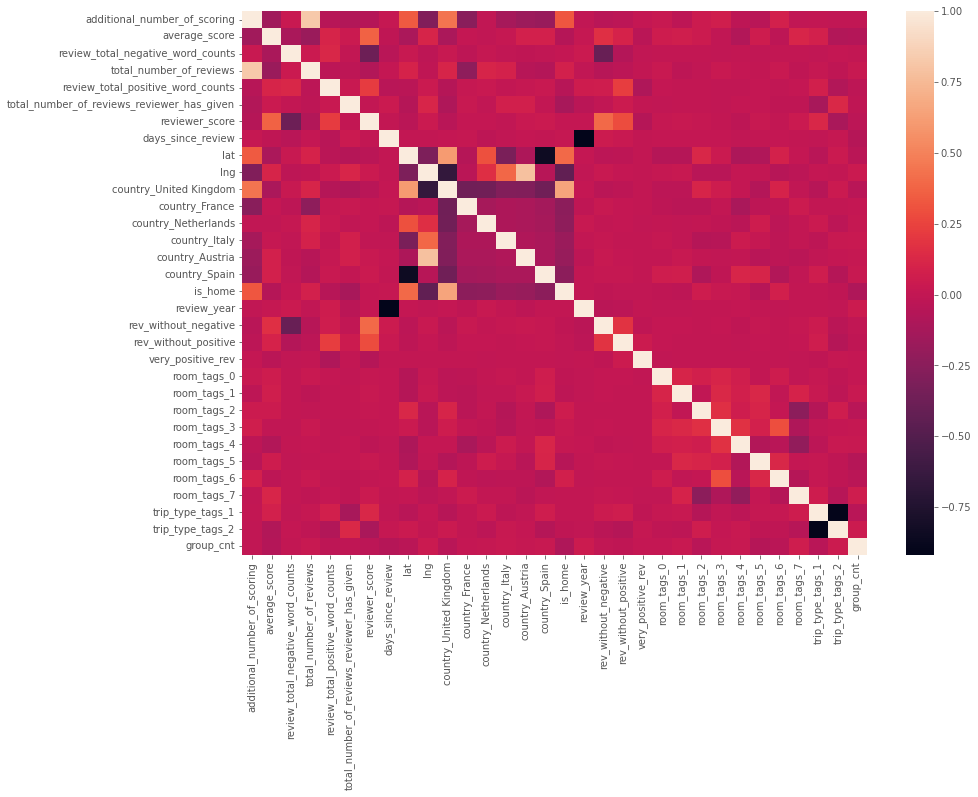

In [34]:
fig, ax1 = plt.subplots(figsize=(14,10))
sns.heatmap(
    corr_df, 
    ax=ax1,
)

In [35]:
X = df.drop('reviewer_score', axis=1)
y = df['reviewer_score']

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [37]:
    # Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
    # Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
    # Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.  
    # Предсказанные значения записываем в переменную y_pred  
y_pred = regr.predict(X_test)

In [38]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test)
    # Метрика Mean Absolute Percentage Error (MAPE)
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.13406261697273544
